In [0]:
from google.colab import drive

drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import re
import numpy as np
import string
from keras.preprocessing.text import Tokenizer
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
# data = pd.read_csv('/content/gdrive/My Drive/lab10/glove.6B.50d.txt')
# data = np.loadtxt('/content/gdrive/My Drive/lab10/glove.6B.50d.txt')

# df = pd.DataFrame(data)

# (data.head())

Using TensorFlow backend.


In [0]:
import os
import numpy as np
import keras
from keras.datasets import reuters, imdb
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, GRU, Dense, Dropout, Activation, Embedding, Bidirectional, CuDNNLSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split, StratifiedKFold
import pandas as pd


# CODE START

In [0]:
EMBEDDING_DIM = 50
# load in training/test set
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/CDS_lab/lab12/project/rat07nodups.csv', encoding='utf-8', index_col=0)
data.head()

# data['label'].value_counts()

,tweet_id,label,text
0,850490912954350976,1,alex brosas another idiot
1,848791766853667968,1,nancy reagan would say say fucking something like
2,850433664890544000,1,hate er chase bitch work shes literally evil
3,850411934205844992,1,sick bitch internet
4,850100742035836032,1,pineapple belong pizza yall nigga nasty


In [0]:
data

,tweet_id,label,text
0,850490912954350976,1,alex brosas another idiot
1,848791766853667968,1,nancy reagan would say say fucking something like
2,850433664890544000,1,hate er chase bitch work shes literally evil
3,850411934205844992,1,sick bitch internet
4,850100742035836032,1,pineapple belong pizza yall nigga nasty
...,...,...,...
21409,850744597030592000,1,plot twist never stopped fucking ðÿœš
21410,849805798540816000,1,want one fucking person one
21411,849736257001463040,1,im like 5 bad day away saying fuck running bud...
21412,848944263366934016,1,chickfilas owner trump supporter damn dat crazy


In [0]:
data['text'] = data['text'].astype('str')

Text(0, 0.5, 'Total Number')

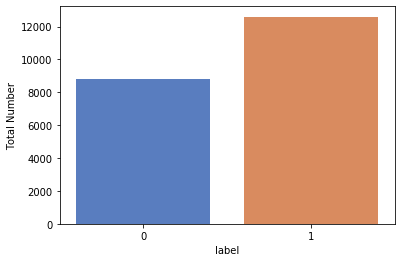

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
#breakdown by class
ax=sns.countplot(x="label", data=data, palette = "muted");
ax.set_ylabel('Total Number')
# ax.set_title('Total Number of Occurrence per Label')

In [0]:
vocab_size = 20000
tokenizer = Tokenizer(num_words= vocab_size)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
word_index = tokenizer.word_index
tweets = sequence.pad_sequences(sequences, padding='post', maxlen=50)
tweets



array([[ 1353, 11400,   138, ...,     0,     0,     0],
       [ 3034,  5027,    34, ...,     0,     0,     0],
       [   13,  3739,  2323, ...,     0,     0,     0],
       ...,
       [    2,     3,   190, ...,     0,     0,     0],
       [ 1492,    32,   929, ...,     0,     0,     0],
       [   98,  2013,   110, ...,     0,     0,     0]], dtype=int32)

In [0]:

labels = data['label']
# labels = labels.replace(4,1) # replace label '4' with '1' to facilitate one-hot encoding
x_train, x_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2)

In [0]:
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

17131 train sequences
4283 test sequences


In [0]:
# convert training and test label to one hot encoding. should print output of ytrain and ytest
y_train = keras.utils.to_categorical(y_train) # 2 classes
y_test = keras.utils.to_categorical(y_test)


In [0]:
print(y_train)
print(y_test)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [0]:
# reading of glove where a dictionary is created. key is the word, value is the word embeddings
embeddings_index = {}
GLOVE_DIR = "/content/gdrive/My Drive/Colab Notebooks/CDS_lab/lab12/project/"
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
print(embeddings_index['user'])

[ 1.2294   -0.17672  -1.0471    0.51638   0.44163  -0.69933   0.90977
 -0.731     0.21802  -0.98615   0.015338  0.079548 -2.4102   -0.89993
 -0.32818  -0.29624   1.0269    0.16989   0.28483  -0.63194  -0.13409
 -0.01479   0.187    -0.026707 -1.027    -0.7028    0.6859   -0.61898
  0.74486   1.0477   -0.65797  -0.20115   0.12543  -1.3197    0.46517
 -0.4721    0.39479  -0.36435  -1.5743   -0.25239  -1.6175    0.34428
 -0.52253  -0.094987 -0.54107  -0.79928  -0.44825  -0.14613  -0.52217
 -0.89081 ]


In [0]:
# embedding matrix only contains the index. initializing all embeddings to zero first

print('Found %s word vectors.' % len(embeddings_index))

## check if a word exists if not it will be zero
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


Found 1193514 word vectors.


In [0]:
print(embeddings_index['hi'])

[ 5.8579e-01  8.0163e-02  1.9010e-01 -4.2974e-01 -6.7700e-01 -7.4183e-01
  2.3548e-01  5.6125e-01  3.4123e-02  6.6093e-01 -6.5666e-01 -3.1038e-01
 -3.3108e+00 -7.2266e-01 -1.8421e+00  9.9063e-01  2.6346e-02 -3.5894e-01
 -3.6259e-01  3.3939e-01  3.6955e-01  1.4748e-01 -4.5263e-01  3.8507e-01
 -5.6107e-01 -4.6079e-01  4.5029e-01 -4.5864e-02  8.2711e-01 -1.8816e-03
  4.5242e-01  6.7928e-01  7.2897e-01  6.7967e-02  3.0747e-01 -3.0777e-02
  1.4615e-01  9.8352e-01  3.0713e-01 -4.0797e-01 -1.6674e+00 -4.8884e-01
 -3.7614e-01  1.1126e+00 -8.0011e-01  2.9470e-01  2.1728e-01 -6.8735e-01
 -2.8111e-01  1.3931e-01]


# Now use LSTM instead


In [0]:
from keras.callbacks import EarlyStopping

# weights is important. it is the initialization of the embedding matrix with the pretrained words
# if using random embeddings, set trainable to True, vice versa
model = Sequential()

model.add(Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False))

# model.add(keras.layers.Dropout(1, noise_shape=None, seed=None))
model.add(Dropout(0.2))
# model.add(LSTM(128)) # 128 is the output
# model.add(Bidirectional(LSTM(128, dropout=drop, recurrent_dropout=0.5), merge_mode="concat") ) # 128 is the output
model.add(Bidirectional(CuDNNLSTM(128), merge_mode="concat") )
# model.add(LSTM(128))
# model.add(CuDNNLSTM(128))
# model.add(SimpleRNN(128))
# model.add(Dense(10))
# model.add(Dropout(0.2))
# model.add(Dense(4))
model.add(Dense(2)) # 2 nodes, one for positive one for negative

model.add(Activation('softmax')) # activation function to generate the class probabilities

print(model.summary())

from keras.utils import plot_model

plot_model(model, to_file='model.png')
## dropout after embedding with 1
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.3, callbacks=[es])

score, acc= model.evaluate(x_test, y_test, batch_size=128, verbose=2)
# score, acc, f1_score, precision, recall = model.evaluate(x_train, y_train, batch_size=128, verbose=1)
print('Test score:', score)
print('Test accuracy:', acc)
# predictions = model.predict_classes(x_test)
predictions = model.predict(x_test)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          1520500   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               184320    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 1,705,334
Trainable params: 184,834
Non-trainable params: 1,520,500
_____________________________________________

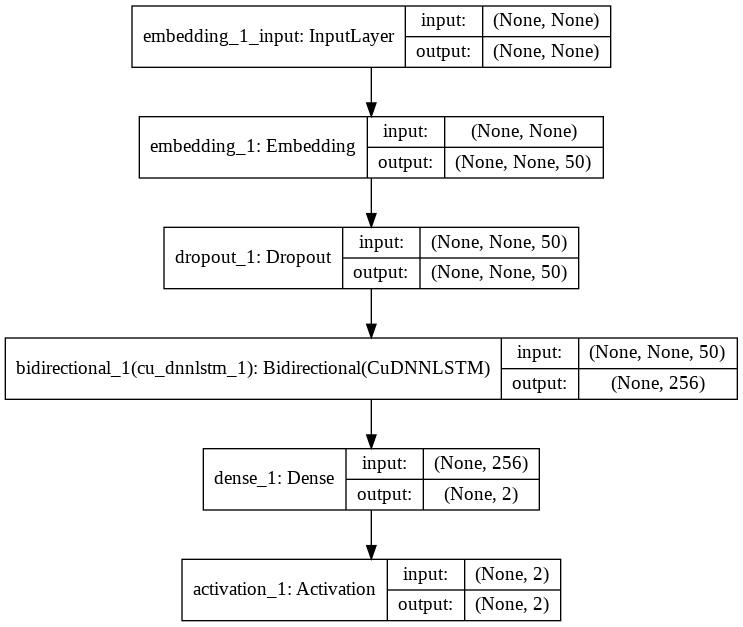

In [0]:
plot_model(model, show_shapes=True, expand_nested= True, to_file='model.png')

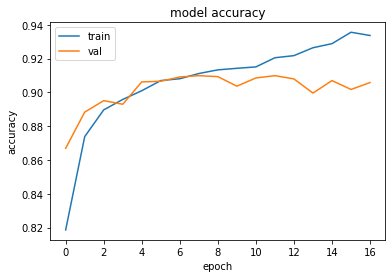

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

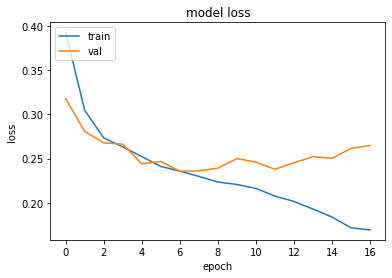

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

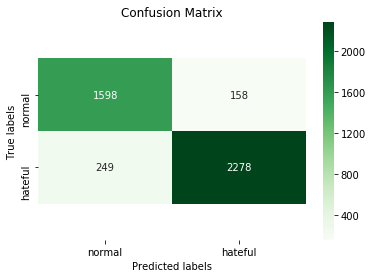

In [0]:
# matrix = metrics.confusion_matrix(y_test.astype(int), predictions.astype(int))
# print(matrix)

import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import model_selection, preprocessing, metrics, svm, ensemble    

# cm =  metrics.confusion_matrix(y_test.astype(int), predictions.astype(int))
cm =  metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

ax= plt.subplot()
ax =sns.heatmap(cm, annot=True, ax = ax,fmt='g',cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
# ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['hateful', 'normal']); ax.yaxis.set_ticklabels(['hateful', 'normal']);
ax.xaxis.set_ticklabels(['normal', 'hateful']); ax.yaxis.set_ticklabels(['normal', 'hateful']);

In [0]:
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]


In [0]:

y_pred_class = model.predict_classes(x_test)
print(y_pred_class)
print("Accuracy: ", (metrics.accuracy_score(y_test.argmax(axis=1), y_pred_class)))
print("Null Accuracy: ", max(y_test.argmax(axis=1).mean(), 1 - y_test.argmax(axis=1).mean()))
print("Misclassification Rate: ",1 - metrics.accuracy_score(y_test.argmax(axis=1), y_pred_class))
recall =metrics.recall_score(y_test.argmax(axis=1), y_pred_class)
print("Recall/Sensitivity: ",recall) #want to maximise
precision =  metrics.precision_score(y_test.argmax(axis=1), y_pred_class)
print("Precision: ",precision)
print("F1 Score: ", 2* ((precision*recall))/(precision+recall))
specificity = TN / (TN + FP)
print("specificity: ", specificity)
print("False Positive Rate: ", 1-specificity)

[1 0 1 ... 1 0 1]
Accuracy:  0.9049731496614523
Null Accuracy:  0.5900070044361428
Misclassification Rate:  0.09502685033854774
Recall/Sensitivity:  0.9014641867827463
Precision:  0.9351395730706076
F1 Score:  0.917993149304856
specificity:  0.9100227790432802
False Positive Rate:  0.08997722095671978


# K-fold Cross Validation

In [0]:

labels = data['label']
# labels = labels.replace(4,1) # replace label '4' with '1' to facilitate one-hot encoding
# x_train, x_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2)

In [0]:
# reading of glove where a dictionary is created. key is the word, value is the word embeddings
embeddings_index = {}
GLOVE_DIR = "/content/gdrive/My Drive/Colab Notebooks/CDS_lab/lab12/project/"
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
# embedding matrix only contains the index. initializing all embeddings to zero first

print('Found %s word vectors.' % len(embeddings_index))

## check if a word exists if not it will be zero
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


Found 1193514 word vectors.


In [0]:
# weights is important. it is the initialization of the embedding matrix with the pretrained words
# if using random embeddings, set trainable to True, vice versa
seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []

X = tweets
Y = labels

for train, test in kfold.split(X, Y):
  # INITIALLY TRIED THIS
  # Y[train] = keras.utils.to_categorical(Y[train])
  # Y[test] = keras.utils.to_categorical(Y[test])

  ## which failed with a broadcasting issue
  # To get it to work, I did this instead
  ytrain = Y[train]
  ytest = Y[test]
  xtrain = X[train]
  xtest = X[test]

  ytrain = keras.utils.to_categorical(ytrain)
  ytest = keras.utils.to_categorical(ytest)

  # create model
  
  model = Sequential()
  model.add(Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False))
  # model.add(CuDNNLSTM(128)) # 128 is the output
  # model.add(LSTM(128))
  model.add(Bidirectional(LSTM(128), merge_mode='concat'))
  model.add(Dense(2)) # 2 nodes, one for positive one for negative
  model.add(Activation('softmax')) # activation function to generate the class probabilities
  # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_m,precision_m, recall_m])
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # history = model.fit(X[train], Y[train], batch_size=128, epochs=5, verbose=1, validation_split=0.2)
  history = model.fit(xtrain, ytrain, batch_size=128, epochs=20, verbose=1)

  score, acc = model.evaluate(xtest, ytest, batch_size=128, verbose=1)

  print("%s: %.2f%%" %(model.metrics_names[1], acc))

  cvscores.append(acc)
  print('Test score:', score)
  print('Test accuracy:', acc)
# predictions = model.predict_classes(x_test)
  predictions = model.predict(x_test)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)) )

Epoch 1/20
19272/19272 [==============================] - 41s 2ms/step - loss: 0.3417 - acc: 0.8557
Epoch 2/20
19272/19272 [==============================] - 29s 1ms/step - loss: 0.2633 - acc: 0.8965
Epoch 3/20
19272/19272 [==============================] - 29s 2ms/step - loss: 0.2390 - acc: 0.9073
Epoch 4/20
19272/19272 [==============================] - 29s 1ms/step - loss: 0.2257 - acc: 0.9136
Epoch 5/20
19272/19272 [==============================] - 29s 1ms/step - loss: 0.2183 - acc: 0.9155
Epoch 6/20
19272/19272 [==============================] - 29s 2ms/step - loss: 0.2117 - acc: 0.9188
Epoch 7/20
19272/19272 [==============================] - 29s 1ms/step - loss: 0.2050 - acc: 0.9213
Epoch 8/20
19272/19272 [==============================] - 29s 2ms/step - loss: 0.1980 - acc: 0.9245
Epoch 9/20
19272/19272 [==============================] - 29s 1ms/step - loss: 0.1884 - acc: 0.9293
Epoch 10/20
19272/19272 [==============================] - 29s 1ms/step - loss: 0.1782 - acc: 0.9336

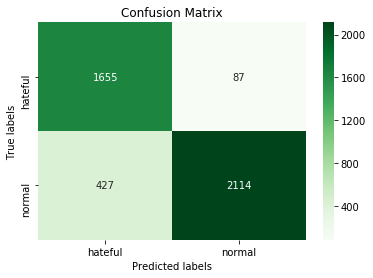

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import model_selection, preprocessing, metrics, svm, ensemble    

# cm =  metrics.confusion_matrix(y_test.astype(int), predictions.astype(int))
cm =  metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

ax= plt.subplot()
ax =sns.heatmap(cm, annot=True, ax = ax,fmt='g',cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
# ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['hateful', 'normal']); ax.yaxis.set_ticklabels(['hateful', 'normal']);

In [0]:
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]


y_pred_class = model.predict_classes(x_test)
print(y_pred_class)
print("Accuracy: ", (metrics.accuracy_score(y_test.argmax(axis=1), y_pred_class)))
print("Null Accuracy: ", max(y_test.argmax(axis=1).mean(), 1 - y_test.argmax(axis=1).mean()))
print("Misclassification Rate: ",1 - metrics.accuracy_score(y_test.argmax(axis=1), y_pred_class))
recall =metrics.recall_score(y_test.argmax(axis=1), y_pred_class)
print("Recall/Sensitivity: ",recall) #want to maximise
precision =  metrics.precision_score(y_test.argmax(axis=1), y_pred_class)
print("Precision: ",precision)
print("F1 Score: ", 2* ((precision*recall))/(precision+recall))
specificity = TN / (TN + FP)
print("specificity: ", specificity)
print("False Positive Rate: ", 1-specificity)

[1 1 1 ... 1 0 1]
Accuracy:  0.9402288115806677
Null Accuracy:  0.5932757413028251
Misclassification Rate:  0.059771188419332266
Recall/Sensitivity:  0.9244391971664699
Precision:  0.9734769995855781
F1 Score:  0.9483245861929754
specificity:  0.9500574052812859
False Positive Rate:  0.049942594718714095


In [0]:
print("null accuracy: ", max(y_test.argmax(axis=1).mean(), 1 - y_test.argmax(axis=1).mean()))

# Finding the best place to put dropout

In [0]:
from keras.callbacks import EarlyStopping

dropoutlist = [0.1,0.2,0.5,0.8,1]

for drop in dropoutlist:
    print('drop out number:', drop)
    # weights is important. it is the initialization of the embedding matrix with the pretrained words
    # if using random embeddings, set trainable to True, vice versa
    model = Sequential()

    model.add(Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False))

    # model.add(keras.layers.Dropout(1, noise_shape=None, seed=None))

    # model.add(LSTM(128)) # 128 is the output
    model.add(Dropout(drop))
    # model.add(Bidirectional(LSTM(128, dropout=drop, recurrent_dropout=0.5), merge_mode="sum") ) # 128 is the output
    model.add(LSTM(128))
    # model.add(Dense(10))
    # model.add(Dropout(0.5))
    # model.add(Dense(4))
    model.add(Dense(2)) # 2 nodes, one for positive one for negative

    model.add(Activation('softmax')) # activation function to generate the class probabilities

    print(model.summary())

    from keras.utils import plot_model

    plot_model(model, to_file='model.png')
    ## dropout after embedding with 1
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_m,precision_m, recall_m])

    es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

    history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.3, callbacks=[es])

    score, acc, f1_score, precision, recall = model.evaluate(x_test, y_test, batch_size=128, verbose=2)
    # score, acc, f1_score, precision, recall = model.evaluate(x_train, y_train, batch_size=128, verbose=1)
    print('Test score:', score)
    print('Test accuracy:', acc)
    print('Test f1 score: ' ,f1_score)
    print('Test precision: ' ,precision)
    print('Test recall: ' ,recall)
    # predictions = model.predict_classes(x_test)
    predictions = model.predict(x_test)

drop out number: 0.1

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 50)          1520500   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 258       
_________________________________________________________________
activation_13 (Activation)   (None, 2)                 0         
Total params: 1,612,406
Trainable params: 91,906
Non-trainable params: 1,520,500
_________________________________

In [0]:
from keras.callbacks import EarlyStopping

# weights is important. it is the initialization of the embedding matrix with the pretrained words
# if using random embeddings, set trainable to True, vice versa
model = Sequential()

model.add(Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False))

# model.add(keras.layers.Dropout(1, noise_shape=None, seed=None))

# model.add(LSTM(128)) # 128 is the output
# model.add(Bidirectional(LSTM(128, dropout=drop, recurrent_dropout=0.5), merge_mode="sum") ) # 128 is the output
model.add(LSTM(128))
# model.add(Dense(10))
# model.add(Dropout(0.5))
# model.add(Dense(4))
model.add(Dense(2)) # 2 nodes, one for positive one for negative

model.add(Activation('softmax')) # activation function to generate the class probabilities

print(model.summary())

from keras.utils import plot_model

plot_model(model, to_file='model.png')
## dropout after embedding with 1
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_m,precision_m, recall_m])

es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.3, callbacks=[es])

score, acc, f1_score, precision, recall = model.evaluate(x_test, y_test, batch_size=128, verbose=2)
# score, acc, f1_score, precision, recall = model.evaluate(x_train, y_train, batch_size=128, verbose=1)
print('Test score:', score)
print('Test accuracy:', acc)
print('Test f1 score: ' ,f1_score)
print('Test precision: ' ,precision)
print('Test recall: ' ,recall)
# predictions = model.predict_classes(x_test)
predictions = model.predict(x_test)










Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          1520500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 1,612,406
Trainable params: 91,906
Non-trainable params: 1,520,500
_________________________________________________________________
None


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 11991 samples, validate on 5140 samples
Epoch 1/50
 - 7s - loss: 0.4049 - acc: 0.8102 - f1_m: 0.8101 - precision_m: 